In [ ]:
import os
import zipfile
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing.image import ImageDataGenerator
from os import getcwd
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import cv2
from google.colab import files
from keras.preprocessing import image
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential

In [ ]:
from google.colab import files
files.upload()
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle (1).json


In [ ]:
!kaggle datasets download -d jerrinbright/cheetahtigerwolf

cheetahtigerwolf.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-06-22 05:56:24--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 2a00:1450:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/content/inception_ 100%[===================>]  83.84M  41.6MB/s    in 2.0s    

2020-06-22 05:56:27 (41.6 MB/s) - ‘/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
local_zip = '/content/-xray.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [ ]:
local_weights = '/content/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
import shutil
shutil.move("/content/TIGER","/content/ANIMALS/",)

'/content/ANIMALS/TIGER'

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = None)

pre_trained_model.load_weights(local_weights)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_510 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 74, 74, 32)   96          conv2d_510[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 74, 74, 32)   0           batch_normalization_470[0][0]    
_______________________________________________________________________________________

In [ ]:
last_output = pre_trained_model.output
conv1 = layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu')(last_output)
conv2 = layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu')(conv1)
pool1 = layers.MaxPooling2D(pool_size = 2)(conv2)
#conv3 = layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu')(pool1)
#conv4 = layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu')(conv3)
#drop2 = layers.Dropout(0.2)(conv4)
#pool2 = layers.MaxPooling2D(pool_size = 2)(conv2)
#conv5 = layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu')(drop2)
#conv6 = layers.Conv2D(filters = 16, kernel_size = 3, padding = 'same', activation = 'relu')(conv5)
#drop3 = layers.Dropout(0.5)(conv4)
flat1 = layers.Flatten()(pool1)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
conv7 = layers.Dense(512, activation='relu')(flat1)
# Add a dropout rate of 0.2
conv8 = layers.Dropout(0.5)(conv7)                  
# Add a final sigmoid layer for classification
final = layers.Dense(11, activation='softmax')(conv8)           

model = Model( pre_trained_model.input, outputs = final) 

In [ ]:
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_510 (Conv2D)             (None, 74, 74, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 74, 74, 32)   96          conv2d_510[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 74, 74, 32)   0           batch_normalization_470[0][0]    
___________________________________________________________________________________________

In [ ]:
DESIRED_ACCURACY = 0.99
class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy')>DESIRED_ACCURACY):
                print("\nReached 99.5% accuracy so cancelling training!")
                self.model.stop_training = True

In [ ]:
#es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience = 10, min_delta=1, baseline=0.95)

In [ ]:
mc = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/yolov3/diseases.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 5, min_lr = 0.01)

In [ ]:
my_callback = [myCallback(), mc, reduce_lr]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
img_width = 150
img_height = 150

datagen = ImageDataGenerator(rescale=1/255.0, validation_split=0.2, width_shift_range=0.1, 
                                      height_shift_range=0.2, zoom_range=0.15, horizontal_flip=True, fill_mode='reflect', samplewise_center=True, 
                                      samplewise_std_normalization=True)
# 1) TRAINING SET
train_generator = datagen.flow_from_directory(directory='/content/XRAY',
                                                   target_size=(img_width, img_height),
                                                   class_mode='binary',
                                                   batch_size=16,
                                                   subset='training'
                                                   )
# 2)CROSS VALIDATION SET
validation_generator = datagen.flow_from_directory(directory='/content/XRAY',
                                                    target_size=(img_width,img_height),
                                                    class_mode='binary',
                                                    batch_size=16,
                                                    subset='validation'
                                                   )

Found 18873 images belonging to 11 classes.
Found 4717 images belonging to 11 classes.


In [ ]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = "Adam", metrics=['accuracy']) 

In [ ]:
history = model.fit(train_generator, steps_per_epoch = 500, epochs=5, validation_data = validation_generator, verbose = 1, callbacks=[my_callback])

Epoch 1/5
500/500 [==============================] - ETA: 0s - loss: 1.8259 - accuracy: 0.3976
Epoch 00001: val_accuracy improved from -inf to 0.38202, saving model to /content/drive/My Drive/yolov3/diseases.h5
500/500 [==============================] - 303s 605ms/step - loss: 1.8259 - accuracy: 0.3976 - val_loss: 1.9634 - val_accuracy: 0.3820 - lr: 0.0010
Epoch 2/5
500/500 [==============================] - ETA: 0s - loss: 1.8305 - accuracy: 0.3923
Epoch 00002: val_accuracy improved from 0.38202 to 0.38478, saving model to /content/drive/My Drive/yolov3/diseases.h5
500/500 [==============================] - 294s 588ms/step - loss: 1.8305 - accuracy: 0.3923 - val_loss: 1.9807 - val_accuracy: 0.3848 - lr: 0.0010
Epoch 3/5
500/500 [==============================] - ETA: 0s - loss: 1.8254 - accuracy: 0.3961
Epoch 00003: val_accuracy did not improve from 0.38478
500/500 [==============================] - 294s 587ms/step - loss: 1.8254 - accuracy: 0.3961 - val_loss: 1.9525 - val_accuracy: 0

In [ ]:
np.savetxt("accloss.csv", (acc,loss,val_acc,val_loss), delimiter = ',')

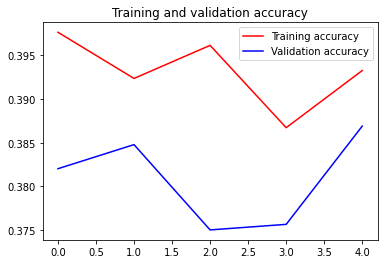

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
new_model = tf.keras.models.load_model("/content/drive/My Drive/yolov3/diseases.h5")

In [ ]:
new_model.compile(loss = 'binary_crossentropy', optimizer = "Adam", metrics=['accuracy']) 

In [ ]:
test_labels = testing_datagen.classes

In [ ]:
testing_datagen.class_indices

In [ ]:
def plot_confusion_matrix(cm, classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [ ]:
cm_plot_labels = ['cat','dog']

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
CATEGORIES = ["Oil_filter", "Screw"]

In [ ]:
upload = files.upload()
print(upload)

In [ ]:
for fn in upload.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x/= 255.
  images = np.vstack([x])
  predict = new_model.predict(images)
  #print(fn)
  print(predict)

[[0.09520517 0.06520377 0.0471668  0.10745768 0.08599038 0.11492063
  0.16954927 0.11551185 0.07198605 0.00226381 0.12474462]]
